## Final Project Submission

Please fill out:
* Student name: Tim Sennett
* Student pace: self paced / **part time** / full time
* Scheduled project review date/time: 
* Instructor name: Abhineet Kulkarni
* Blog post URL: https://medium.com/@timsennett/

The project I've chosen for the end of Module 4 is "Image Classification with Deep Learning".

Generally speaking, my aim is to build a deep neural network that trains on a large dataset for classification on a non-trivial task. In this case, that will entail building a model that can classify whether a given pediatric patient has pneumonia, given a chest x-ray image. The dataset comes from Kermany et al. on [Mendely](https://data.mendeley.com/datasets/rscbjbr9sj/3). Serious business!

Needless to say, the stakes for this kind of problem domain are higher than most. It's not going to be good enough to simply build a model; the model actually *has to work*. At the same time, I need to demonstrate my understanding of the task by taking an iterative approach to modeling, in such a way that each model builds on and improves upon earlier ones.

### Following the [OSEMN framework](https://towardsdatascience.com/5-steps-of-a-data-science-project-lifecycle-26c50372b492), the present notebook is organized according to the following basic steps:

1. Obtain
2. Scrub
3. Explore
4. Model
5. Interpret

## 1. Obtain
#### Gathering data from the relevant sources.

In [367]:
# Import libraries that I anticipate using

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
# from tensorflow import keras
from keras import models
from keras import layers
from keras.layers import LeakyReLU
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# from keras.applications import

import os, shutil

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [305]:
# Define visualization function for evaluating model performances

def visualize(model_history):
    '''Returns visualization of model training history'''
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    tn = model_history.history['specificity']
    val_tn = model_history.history['val_specificity']
    epochs = range(len(acc))
    plt.figure(figsize=(8,5))
    plt.plot(epochs, acc, 'bo', color='green', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'bo', color='orange',
             label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.figure(figsize=(8,5))
    plt.plot(epochs, loss, 'bo', color='green', label='Training Loss')
    plt.plot(epochs, val_loss, 'bo', color='orange', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Crossentropy (Loss)')
    plt.legend()
    plt.figure(figsize=(8,5))
    plt.plot(epochs, tn, 'bo', color='green', label='Training Specificity')
    plt.plot(epochs, val_tn, 'bo', color='orange',
             label='Validation Specificity')
    plt.title('Training and Validation Specificity')
    plt.xlabel('Epochs')
    plt.ylabel('Specificity (True Negative Rate)')
    plt.legend()
    plt.show();

In [131]:
# Define function for Specificity metric (i.e., True Negative rate)

def specificity(y_true, y_pred):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

The image data for this project was obtained from [Mendely](https://data.mendeley.com/datasets/rscbjbr9sj/3). It includes a zip drive containing two folders: train and test samples of chest X-ray images.

There are 5232 files in the train folder, and 624 images in the test folder. The samples are labeled as either `Normal` or `Pneumonia`. I manually created a third folder to store a validation set, which I obtained by manually moving 32 files from the test folder (16 from each of the two classes, including an equal number of viral and bacterial pneumonia samples). 

In the next cell, I'll check to see what's in the current repository. I want to be sure to load the appropriate data.

In [2]:
ls

Untitled.ipynb                        chest_xray_with_augmentation_data.h5
chest_xray/                           student.ipynb
chest_xray_cnn_baseline.h5            vgg19_20epochs.h5
chest_xray_dense_baseline.h5          vgg19_50epochs.h5


## 2. Scrub / Preprocessing
#### Clean data to format that machine understands.

Now that I've downloaded the data, its time to prepare it for some model building. Even though it's not likely to produce great results, I'll start by preparing the data for a densely connected baseline model.

In [3]:
# make directory path strings
train_data_dir = 'chest_xray/train'
val_data_dir = 'chest_xray/val'
test_data_dir = 'chest_xray/test'

The generators I'm making in the next cell are primarily geared toward some exploration I'd like to do before getting into some of the more rigorous modeling work. This explains why, for now, I'm going to set batch-sizes equal to each set's sample size, when ordinarily a batch size would be much smaller.

In these next few cells I'll grab and reshape the data in my train, test, and validation sets.

In [56]:
# Scale each pixel-value (1–255) between 0 and 1
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir,
        # images will be resized to 256x256
        target_size=(256, 256),
        batch_size=5232,
        )

# Get all the data in the directory chest_xray/val (32 images), and reshape
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_data_dir, 
        target_size=(256, 256),
        batch_size=32,
        )

# Get all the data in the directory chest_xray/test (592 images), and reshape
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_dir, 
        target_size=(256, 256),
        batch_size=592,
        )

Found 5232 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Found 592 images belonging to 2 classes.


Since Python reads images as three matrices (which correspond with three color channels—red, green and blue, or RBG), and since the numbers in those matrices correspond with the pixel-intensity values in each of the three colors (in this case, 256 by 256), I'll need to modify this shape to get to one input feature vector. That means I must "unrow" the input feature values into one "feature vector".

In [57]:
# Create features and labels out of each set
# This will take about 2 minutes to run

train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [58]:
# Check dimensionality of arrays before unrowing

m_train = train_images.shape[0]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val),'\n')
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape),'\n')
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape),'\n')
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5232
Number of testing samples: 592
Number of validation samples: 32 

train_images shape: (5232, 256, 256, 3)
train_labels shape: (5232, 2) 

test_images shape: (592, 256, 256, 3)
test_labels shape: (592, 2) 

val_images shape: (32, 256, 256, 3)
val_labels shape: (32, 2)


In [59]:
# reshape train images to 2-D matrix
train_img = train_images.reshape(train_images.shape[0], -1)
# reshape test images
test_img = test_images.reshape(test_images.shape[0], -1)
# reshape val images
val_img = val_images.reshape(val_images.shape[0], -1)

# Do I need to transpose these too? (.T) Ask Abhineet

In [61]:
train_y = np.reshape(train_labels[:,0], (5232,))
test_y = np.reshape(test_labels[:,0], (592,))
val_y = np.reshape(val_labels[:,0], (32,))

Now that the data has been preprocessed for further exploration, let's take a closer look.

## 3. Explore

Now would be a good time to make sure that the data is shaped as expected after the steps taken in the previous cells.

In [62]:
# Preview the shapes of now unrowed/reshaped features
print('Dimentionality of image data:')
print(np.shape(train_img))
print(np.shape(test_img))
print(np.shape(val_img),'\n')

# Preview the shapes of now unrowed/reshaped labels
print('Dimentionality of labels:')
print(np.shape(train_y))
print(np.shape(test_y))
print(np.shape(val_y))

Dimentionality of image data:
(5232, 196608)
(592, 196608)
(32, 196608) 

Dimentionality of labels:
(5232,)
(592,)
(32,)


Because I made the choice early on to set the batch-sizes to be equal to my train/test/val sample sizes, respectively, I can have some fun and view any of the 5,856 images at my disposal!

0.0


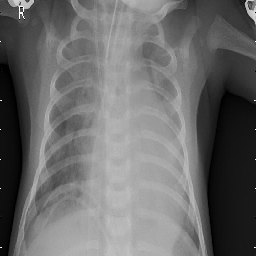

In [63]:
# preview example image and corresponding label

print(train_y[99])
array_to_img(train_images[99])

My untrained eye would never be able to detect pneumonia in any of those images. Thankfully, we have neural networks for that!

## 4. Model
#### Construct models to predict and forecast

Here in the modeling phase, I'm interested in building not one but several models, tinkering with different architectures and parameters. Along the way I'll try to discern what works well, and hopefully will arrive at some strong results.

### I. Baseline densely-connected network

To start, I'll build a fully connected (Dense) layer network with relu activation in Keras.

The network below includes two hidden layers with 128 units in the first layer and 64 in the second, both with a 'relu' activation function. Because I'm dealing with a binary problem (classifying the images into one of two categories), I'm using a 'sigmoid' classifier in order to squeeze the output to a value between 0 and 1. Any output closer to 0 will be predicted to belong to the negative class ("Normal"), and anything closer to 1 will be predicted to belong to the positive class ("Pneumonia").

In [285]:
# Build a baseline fully connected model

dense_baseline = models.Sequential()

# input layer
dense_baseline.add(layers.Dense(64, activation='relu', input_shape=(196608,)))

# first hidden layer
dense_baseline.add(layers.Dense(128, activation='relu'))
# second hidden layer
dense_baseline.add(layers.Dense(64, activation='relu'))

# output layer
dense_baseline.add(layers.Dense(1, activation='sigmoid'))

In [286]:
# This will take about 30 minutes to run

dense_baseline.compile(optimizer='sgd',
                       loss='binary_crossentropy',
                       metrics=['acc', specificity])

dense_baseline_history = dense_baseline.fit(train_img,
                                            train_y,
                                            epochs=50,
                                            # divisible by train size (5232)
                                            batch_size=48,
                                            validation_data=(val_img, val_y))

Train on 5232 samples, validate on 32 samples
Epoch 1/50
5232/5232 [==============================] - 91s 17ms/step - loss: 0.6162 - acc: 0.7278 - specificity: 0.9666 - val_loss: 0.8413 - val_acc: 0.5000 - val_specificity: 1.0000
Epoch 2/50
5232/5232 [==============================] - 26s 5ms/step - loss: 0.4322 - acc: 0.7351 - specificity: 0.9807 - val_loss: 0.6844 - val_acc: 0.5000 - val_specificity: 1.0000
Epoch 3/50
5232/5232 [==============================] - 25s 5ms/step - loss: 0.3599 - acc: 0.8261 - specificity: 0.9590 - val_loss: 0.8799 - val_acc: 0.5938 - val_specificity: 1.0000
Epoch 4/50
5232/5232 [==============================] - 36s 7ms/step - loss: 0.3381 - acc: 0.8681 - specificity: 0.9063 - val_loss: 0.6184 - val_acc: 0.8125 - val_specificity: 0.9375
Epoch 5/50
5232/5232 [==============================] - 33s 6ms/step - loss: 0.2921 - acc: 0.9019 - specificity: 0.9388 - val_loss: 0.5235 - val_acc: 0.7812 - val_specificity: 0.6875
Epoch 6/50
5232/5232 [================

5232/5232 [==============================] - 23s 4ms/step - loss: 0.1102 - acc: 0.9622 - specificity: 0.9744 - val_loss: 0.7400 - val_acc: 0.8125 - val_specificity: 0.9375
Epoch 46/50
5232/5232 [==============================] - 24s 5ms/step - loss: 0.1119 - acc: 0.9622 - specificity: 0.9760 - val_loss: 0.6463 - val_acc: 0.8438 - val_specificity: 0.9375
Epoch 47/50
5232/5232 [==============================] - 25s 5ms/step - loss: 0.1112 - acc: 0.9618 - specificity: 0.9725 - val_loss: 0.5514 - val_acc: 0.8750 - val_specificity: 0.9375
Epoch 48/50
5232/5232 [==============================] - 21s 4ms/step - loss: 0.1242 - acc: 0.9557 - specificity: 0.9728 - val_loss: 0.6811 - val_acc: 0.8125 - val_specificity: 0.9375
Epoch 49/50
5232/5232 [==============================] - 22s 4ms/step - loss: 0.1091 - acc: 0.9608 - specificity: 0.9748 - val_loss: 0.6082 - val_acc: 0.8750 - val_specificity: 0.9375
Epoch 50/50
5232/5232 [==============================] - 22s 4ms/step - loss: 0.1139 - acc: 

In [287]:
# save model
dense_baseline.save('chest_xray_dense_baseline.h5')

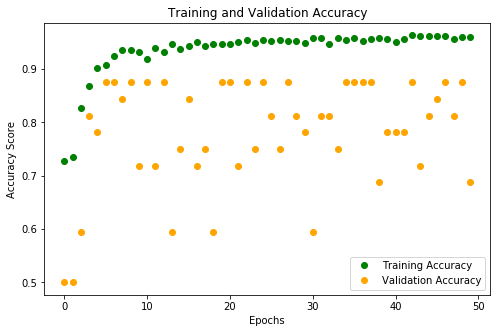

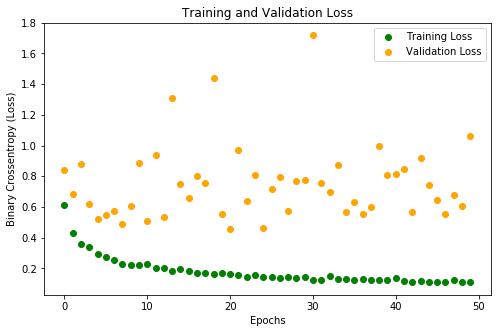

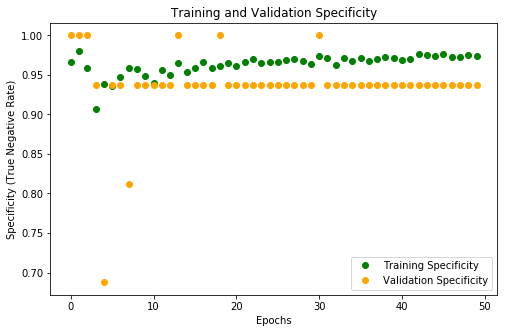

In [306]:
visualize(dense_baseline_history)

Finally, in this evaluation step, I'll print the loss, accuracy, and specificity score for both the train and test sets of the trained model.

In [296]:
# evaluate model on training set
dense_baseline_train_results = dense_baseline.evaluate(train_img, train_y)
print(f"Train loss: {dense_baseline_train_results[0]}")
print(f"Train accuracy: {dense_baseline_train_results[1]}")
print(f"Train specificity: {dense_baseline_train_results[2]}")

Train loss: 0.11739072572177886
Train accuracy: 0.9554663608562691
Train specificity: 0.9907824448124714


In [295]:
# evaluate model on test set
dense_baseline_test_results = dense_baseline.evaluate(test_img, test_y)
print(f"Test loss: {dense_baseline_test_results[0]}")
print(f"Test accuracy: {dense_baseline_test_results[1]}")
print(f"Test specificity: {dense_baseline_test_results[2]}")

Test loss: 0.8554745558145884
Test accuracy: 0.7888513513513513
Test specificity: 0.9948519951588398


**Specificity** was included as a custom metric due to the particular domain problem at hand. When attempting such a non-trivial task as diagnosing pneumonia in children, it's important to know more than merely how accurate my model is, but to know the rate of negative cases (non-pneumonia) that my model correctly identifies as such. This doesn't happen to be my domain of expertise, but I would like to see accuracy and specificity scores in the mid-to-high-90s.

**Some observations**:

- There is a very large (74-points) difference in loss between the training and test sets, indicating that something is awry here, despite high specificity with both sets.
- My baseline fully connected model shows 95% accuracy on the training set, but only 75% accuracy on the test set, indicating a likelihood of being overfit to the training data.
- The True-Negative rate (i.e., specificity)—which measures the proportion of actual negatives that are correctly identified as such—is nearly identical between the training and test sets, even while the test set sees a large dip in accuracy. This could mean that the trained model is predicting a much higher share of negatives than there actually are.
- It stands to reason that where accuracy and specificity are high, loss (in this case, binary crossentropy) would be low, as seen in the evaluation of the training set. But it looks like where either accuracy or specificity are low, loss increases correspondingly. The high specificity score on the testing set is rather unremarkable once one notices the disproportionately low accuracy score, and surmises that such results likely come with a very low sensitivity score (True Positive rate) as well.

**Note**: *Binary crossentropy measures how far away from the true value (which is either 0 or 1) the prediction is for each of the classes and then averages these class-wise errors to obtain the final loss.*

### II. Baseline CNN

Although adapting a pretrained model will produce better results (and I'll get to doing that soon), for now I'm curious to see what will result from a baseline CNN made from scratch.

In [336]:
# Get all the data in the directory chest_xray/train (5232 images)
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir,
        # All images will be resized to 128x128
        target_size=(128, 128),
        batch_size=48,
        class_mode='binary'
        )

# Get all the data in the directory chest_xray/val (32 images)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_data_dir, 
        target_size=(128, 128),
        batch_size=8,
        class_mode='binary'
        )

Found 5232 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [27]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

At this time I'll put together an architecture for my own CNN, using Keras.

In doing this, it'll be important for me to alternate between convolution and pooling layers. The former is used for detecting patterns (e.g., edges and other basic shapes), while the latter is meant to downsample the previous convolutional layers in order to produce manageable execution times in the model training. Max pooling, which is the most common type, takes the max of all convolutions from a larger area of the original image.

In [267]:
cnn_baseline = models.Sequential()

# alternate convolutional and pooling layers
cnn_baseline.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3)))
cnn_baseline.add(layers.MaxPooling2D((2, 2)))
cnn_baseline.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_baseline.add(layers.MaxPooling2D((2, 2)))

# later layers should have a larger number of parameters
# in order to detect more abstract patterns
cnn_baseline.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_baseline.add(layers.MaxPooling2D((2, 2)))
cnn_baseline.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_baseline.add(layers.MaxPooling2D((2, 2)))
cnn_baseline.add(layers.Flatten())

# add some final dense layers to add a classifier to the convolutional base
cnn_baseline.add(layers.Dense(512, activation='relu'))
cnn_baseline.add(layers.Dense(1, activation='sigmoid'))

In [268]:
cnn_baseline.compile(loss='binary_crossentropy',
                     optimizer=optimizers.RMSprop(lr=1e-4),
                     metrics=['acc', specificity])

In [269]:
# This will take about 1.75 hours to run

cnn_baseline_history = cnn_baseline.fit_generator(train_generator, 
                                                  steps_per_epoch=109,
                                                  epochs=30, 
                                                  validation_data=val_generator, 
                                                  validation_steps=4,
                                                  shuffle=True)

Epoch 1/30
109/109 [==============================] - 271s 2s/step - loss: 0.4373 - acc: 0.8047 - specificity: 0.3164 - val_loss: 0.4255 - val_acc: 0.8125 - val_specificity: 1.0000
Epoch 2/30
109/109 [==============================] - 236s 2s/step - loss: 0.2183 - acc: 0.9130 - specificity: 0.8064 - val_loss: 0.3954 - val_acc: 0.8750 - val_specificity: 0.6500
Epoch 3/30
109/109 [==============================] - 224s 2s/step - loss: 0.1598 - acc: 0.9396 - specificity: 0.8788 - val_loss: 0.9673 - val_acc: 0.5938 - val_specificity: 0.1875
Epoch 4/30
109/109 [==============================] - 214s 2s/step - loss: 0.1370 - acc: 0.9467 - specificity: 0.9005 - val_loss: 0.4493 - val_acc: 0.8750 - val_specificity: 0.8250
Epoch 5/30
109/109 [==============================] - 210s 2s/step - loss: 0.1149 - acc: 0.9553 - specificity: 0.9148 - val_loss: 0.4048 - val_acc: 0.8750 - val_specificity: 0.8125
Epoch 6/30
109/109 [==============================] - 207s 2s/step - loss: 0.1021 - acc: 0.9616

In [270]:
cnn_baseline.save('chest_xray_cnn_baseline.h5')

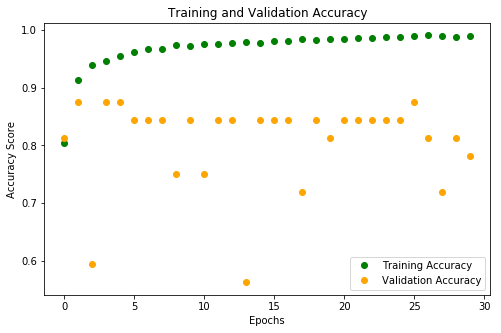

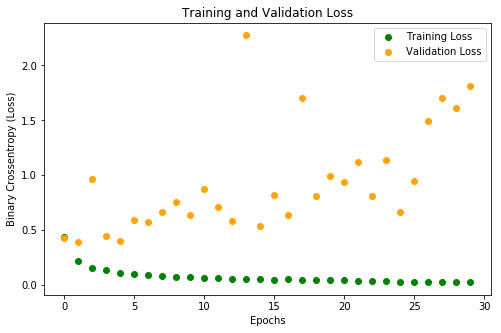

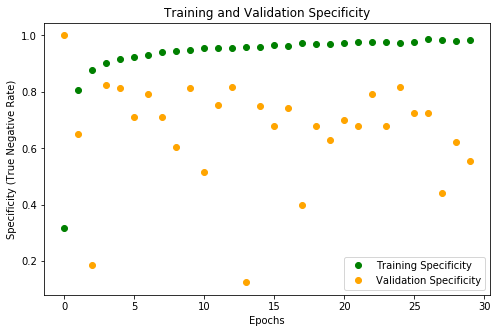

In [307]:
visualize(cnn_baseline_history)

In [337]:
# evaluate on test set
# This will take about 3.5 minutes to execute

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_dir, 
        target_size=(128, 128),
        batch_size=37,
        class_mode='binary'
        )

test_loss, test_acc, test_tn = cnn_baseline.evaluate_generator(test_generator, steps=16)
y_hat_test = cnn_baseline.predict_generator(test_generator, steps=16)
print('Generated {} predictions'.format(len(y_hat_test)))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test specificity:', test_tn)

Found 592 images belonging to 2 classes.
Generated 592 predictions
Test loss: 1.3015071973204613
Test accuracy: 0.8125
Test specificity: 0.48954111337661743


**Some observations**:

- According to the training history and the above visualization, the loss score on the validation data actually trended upward as the epochs went on. In turn, the loss on the testing set is alos quite high.
- The testing specificity score is just under 50%, meaning that *the model only correctly identified roughly half of the negative cases*.
- The model is very clearly overfit to the training set, as apparent from the training history plots.
- Data augmentation could be a key remedy.

### III. Baseline CNN with Data Augmentation

Carrying on, I'll now build another baseline convolution network. Only this time I'm going to implement data augmentation, considered a crucial step when using a small dataset such as mine.

Generally speaking, data augmentation allows a significant increase in the diversity of data available for training models, without actually needing new data to be collected. Techniques such as cropping, padding, and horizontal flipping are commonly used data augmentation techniques used to train large neural networks. Essentially, these techniques allow the pixels around the edges to be be treated no differently, and seen just as often, when run through the training steps. `ImageDataGenerator()` becomes very handy in this regard.

In [272]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# Get all the data in the directory chest_xray/train (5232 images)
train_generator = train_datagen.flow_from_directory(
        train_data_dir, 
        target_size=(128, 128), 
        batch_size = 48, 
        class_mode='binary')

# Get all the data in the directory chest_xray/val (32 images)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_data_dir, 
        target_size=(128, 128),
        batch_size = 8,
        class_mode='binary')

Found 5232 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


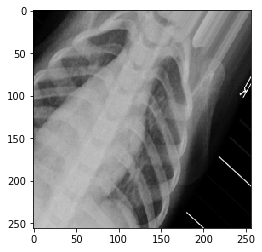

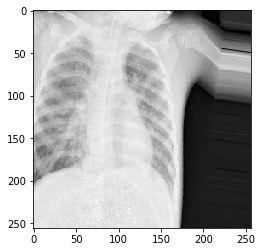

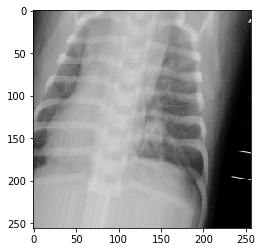

In [38]:
# preview some augmented images

i = 0
for batch in train_datagen.flow(train_images, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()

In [273]:
cnn_baseline_aug = models.Sequential()
cnn_baseline_aug.add(layers.Conv2D(32, (3, 3), activation='relu',
                                   input_shape=(128, 128,  3)))
cnn_baseline_aug.add(layers.MaxPooling2D((2, 2)))

cnn_baseline_aug.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_baseline_aug.add(layers.MaxPooling2D((2, 2)))

cnn_baseline_aug.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_baseline_aug.add(layers.MaxPooling2D((2, 2)))

cnn_baseline_aug.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_baseline_aug.add(layers.MaxPooling2D((2, 2)))

cnn_baseline_aug.add(layers.Flatten())
cnn_baseline_aug.add(layers.Dense(512, activation='relu'))
cnn_baseline_aug.add(layers.Dense(1, activation='sigmoid'))

In [274]:
cnn_baseline_aug.compile(loss='binary_crossentropy',
                         optimizer=optimizers.RMSprop(lr=1e-4),
                         metrics=['acc', specificity])

In [275]:
# This will take a little over 3 hours to run

cnn_baseline_aug_history = cnn_baseline_aug.fit_generator(train_generator, 
                                         steps_per_epoch=109,
                                         # increase epochs
                                         epochs=50, 
                                         validation_data=val_generator, 
                                         validation_steps=4,
                                         shuffle=True)

Epoch 1/50
109/109 [==============================] - 245s 2s/step - loss: 0.5572 - acc: 0.7433 - specificity: 0.0640 - val_loss: 0.8805 - val_acc: 0.5000 - val_specificity: 0.0000e+00
Epoch 2/50
109/109 [==============================] - 229s 2s/step - loss: 0.4717 - acc: 0.7800 - specificity: 0.4126 - val_loss: 0.5299 - val_acc: 0.7500 - val_specificity: 0.6792
Epoch 3/50
109/109 [==============================] - 228s 2s/step - loss: 0.4200 - acc: 0.8098 - specificity: 0.5289 - val_loss: 0.4883 - val_acc: 0.7500 - val_specificity: 0.9643
Epoch 4/50
109/109 [==============================] - 227s 2s/step - loss: 0.3808 - acc: 0.8249 - specificity: 0.6057 - val_loss: 0.4566 - val_acc: 0.8750 - val_specificity: 0.9583
Epoch 5/50
109/109 [==============================] - 234s 2s/step - loss: 0.3539 - acc: 0.8452 - specificity: 0.6695 - val_loss: 0.4066 - val_acc: 0.8750 - val_specificity: 0.9583
Epoch 6/50
109/109 [==============================] - 230s 2s/step - loss: 0.3327 - acc: 0.

109/109 [==============================] - 232s 2s/step - loss: 0.1599 - acc: 0.9383 - specificity: 0.8888 - val_loss: 0.1723 - val_acc: 0.9375 - val_specificity: 0.7500
Epoch 47/50
109/109 [==============================] - 228s 2s/step - loss: 0.1694 - acc: 0.9360 - specificity: 0.8832 - val_loss: 0.1571 - val_acc: 0.9688 - val_specificity: 1.0000
Epoch 48/50
109/109 [==============================] - 232s 2s/step - loss: 0.1621 - acc: 0.9407 - specificity: 0.8923 - val_loss: 0.1357 - val_acc: 0.9062 - val_specificity: 1.0000
Epoch 49/50
109/109 [==============================] - 228s 2s/step - loss: 0.1591 - acc: 0.9406 - specificity: 0.8868 - val_loss: 0.2547 - val_acc: 0.9062 - val_specificity: 1.0000
Epoch 50/50
109/109 [==============================] - 228s 2s/step - loss: 0.1736 - acc: 0.9358 - specificity: 0.8750 - val_loss: 0.1938 - val_acc: 0.9062 - val_specificity: 0.8375


In [276]:
cnn_baseline_aug.save('chest_xray_with_augmentation_data.h5')

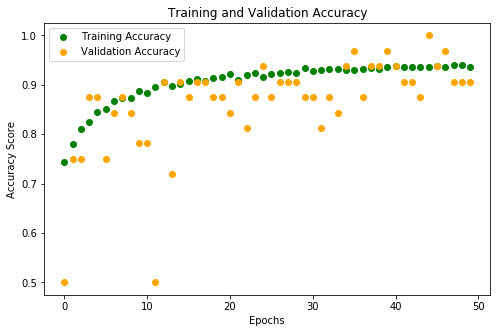

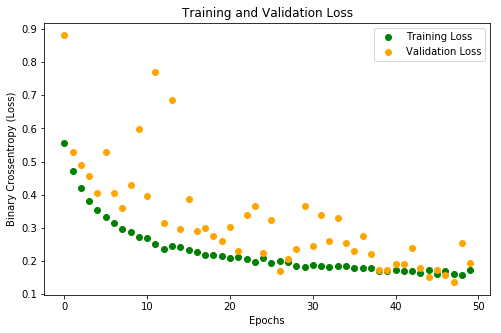

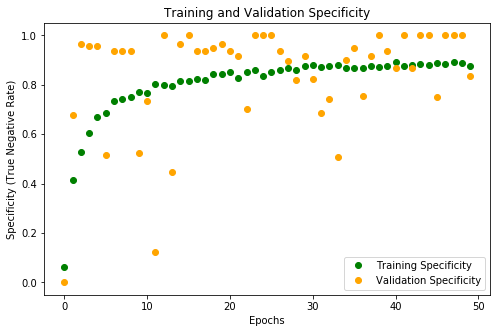

In [308]:
visualize(cnn_baseline_aug_history)

In [335]:
# evaluate on test set
# This will take about 30 seconds to execute

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                    test_data_dir,
                    target_size=(128, 128),
                    batch_size=37,
                    class_mode='binary'
                    )

test_loss, test_acc, test_tn = cnn_baseline_aug.evaluate_generator(test_generator, steps=16)
y_hat_test = cnn_baseline_aug.predict_generator(test_generator, steps=16)
print('Generated {} predictions'.format(len(y_hat_test)))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test specificity:', test_tn)

Found 592 images belonging to 2 classes.
Generated 592 predictions
Test loss: 0.21305974200367928
Test accuracy: 0.9222972951829433
Test specificity: 0.8226029463112354


Now that's more like it!

**Some observations**:

- Having performed augmentation, the model showed 92% accuracy on the testing set while correctly classifying 82% of negative cases.
- See how the plot of the validation history tracks more-or-less with the plot of the training history. A big improvement from previous attempts.
- The metrics are stronger across the board due to data augmentation, even while leaving most of the other parameters the same. Obviously, this is a powerful technique! Especially when working with a relatively limited amount of data.
- Although I did run more epochs this time around (50), the model apparently could have benefited from even more, as the above plots show that loss was still trending downward by the time training had ended.

### IV. Pretrained Network + CNN (Feature Extraction Method 1)

Next, as I aim to improve my results further, I'm going to look to **transfer learning**. This is nothing more than adapting a pre-trained model (ideally from a similar problem context—in this case, image classification) that was trained on a larger dataset. When working with relatively limited data, as I am, this can lead to stronger overall models.

In image recognition, the [VGG-19](https://keras.io/api/applications/) network is commonly used to improve the model performance of CNNs. This particular network was trained on the ImageNet dataset, which contains approximately 1.2 million images. Since the initial, or "bottom" layers of a CNN pick up small, general patterns, with later layers picking up larger and more complex features, those bottom layers of a well-trained network can be well-suited to other problem domains.

The feature-extraction benefit of transfer learning can be accomplished in one of two ways. I'll take a shot at both, beginning with a fairly straightforward method that involves running the convolution base (VGG-19) over my dataset, saving its output, and then using this data as input to a new, standalone, densely-connected network. This should go relatively quickly. **The major drawback of this approach is that I don't have the option to augment my data**. That won't be a problem, as I'll later demonstrate, using the second feature-extraction method offered by transfer learning.

In [178]:
# Initialize Base
from keras.applications import VGG19
cnn_base_1 = VGG19(weights='imagenet',
                   # I only want to take advantage of the bottom layers
                   include_top=False,
                   input_shape=(128, 128, 3))

In [179]:
cnn_base_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

Notice the shape of the topmost layer here. I'm going to plug those numbers (4, 4, 512) right into the `extract_features` function defined below. This function will be used to run the VGG-19 base over my data, preparing it to be fed into a standalone model.

In [181]:
datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 16

def extract_features(directory, sample_amount):
    features = np.zeros(shape=(sample_amount, 4, 4, 512)) 
    labels = np.zeros(shape=(sample_amount))
    generator = datagen.flow_from_directory(
        directory, target_size=(128, 128),
        # batch_size should be divisible by samples_sizes
        batch_size=16,
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = cnn_base_1.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

In [182]:
# This will take about 26 minutes to execute

train_features, train_labels = extract_features(train_data_dir, 5232) 
validation_features, validation_labels = extract_features(val_data_dir, 32) 
test_features, test_labels = extract_features(test_data_dir, 592)

train_features = np.reshape(train_features, (5232, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (32, 4 * 4 * 512))
test_features = np.reshape(test_features, (592, 4 * 4 * 512))

Found 5232 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Found 592 images belonging to 2 classes.


In [195]:
# define model architecture
tl_cnn_model = models.Sequential()
tl_cnn_model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
tl_cnn_model.add(layers.Dense(1, activation='sigmoid'))

# compile the model
tl_cnn_model.compile(loss='binary_crossentropy',
                     optimizer=optimizers.RMSprop(lr=1e-4),
                     metrics=['acc', specificity])

In [199]:
tl_cnn_model_history = tl_cnn_model.fit(train_features, train_labels,
                                        epochs=50,
                                        # Sample size (5232) / default batch size (32) = 163.5
                                        steps_per_epoch=163,
                                        validation_data=(validation_features, validation_labels),
                                        validation_steps=4)

Train on 5232 samples, validate on 32 samples
Epoch 1/50
163/163 [==============================] - 137s 842ms/step - loss: 0.1481 - acc: 0.9423 - specificity: 0.8672 - val_loss: 0.6469 - val_acc: 0.6875 - val_specificity: 0.3750
Epoch 2/50
163/163 [==============================] - 141s 864ms/step - loss: 0.0647 - acc: 0.9773 - specificity: 0.9563 - val_loss: 0.3660 - val_acc: 0.8438 - val_specificity: 0.6875
Epoch 3/50
163/163 [==============================] - 152s 935ms/step - loss: 0.0430 - acc: 0.9850 - specificity: 0.9704 - val_loss: 0.9549 - val_acc: 0.6562 - val_specificity: 0.3125
Epoch 4/50
163/163 [==============================] - 147s 901ms/step - loss: 0.0302 - acc: 0.9905 - specificity: 0.9826 - val_loss: 0.6834 - val_acc: 0.7812 - val_specificity: 0.5625
Epoch 5/50
163/163 [==============================] - 148s 908ms/step - loss: 0.0216 - acc: 0.9949 - specificity: 0.9915 - val_loss: 0.7765 - val_acc: 0.7500 - val_specificity: 0.5000
Epoch 6/50
163/163 [==============

163/163 [==============================] - 136s 833ms/step - loss: 5.5181e-05 - acc: 1.0000 - specificity: 1.0000 - val_loss: 2.0215 - val_acc: 0.7188 - val_specificity: 0.4375
Epoch 45/50
163/163 [==============================] - 136s 834ms/step - loss: 1.2572e-04 - acc: 1.0000 - specificity: 1.0000 - val_loss: 2.1638 - val_acc: 0.7188 - val_specificity: 0.4375
Epoch 46/50
163/163 [==============================] - 146s 895ms/step - loss: 3.9499e-05 - acc: 1.0000 - specificity: 1.0000 - val_loss: 0.8103 - val_acc: 0.8750 - val_specificity: 0.8125
Epoch 47/50
163/163 [==============================] - 159s 976ms/step - loss: 1.1632e-04 - acc: 1.0000 - specificity: 1.0000 - val_loss: 2.0815 - val_acc: 0.7188 - val_specificity: 0.4375
Epoch 48/50
163/163 [==============================] - 151s 926ms/step - loss: 1.1731e-04 - acc: 1.0000 - specificity: 1.0000 - val_loss: 2.6172 - val_acc: 0.6562 - val_specificity: 0.3125
Epoch 49/50
163/163 [==============================] - 155s 949ms/s

In [202]:
# save model
tl_cnn_model.save('vgg19_50epochs_featext_method1.h5')

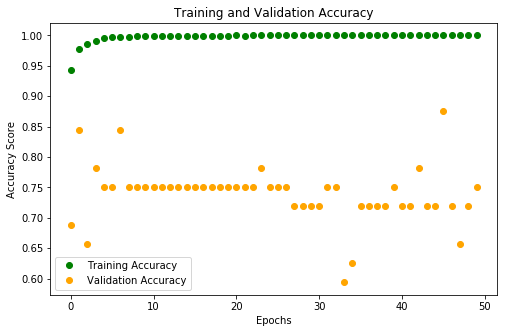

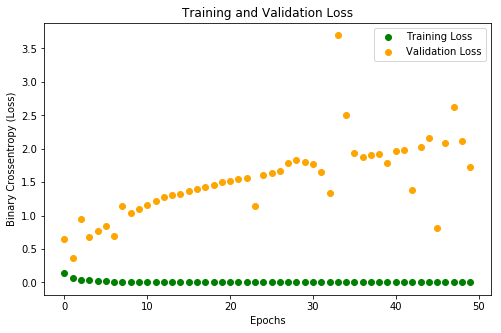

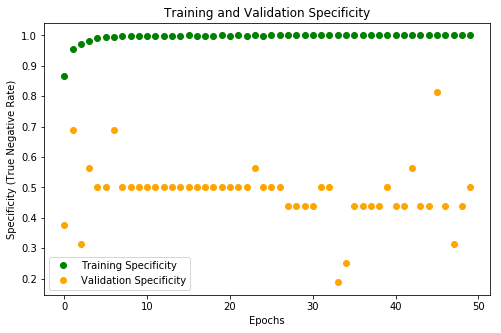

In [309]:
visualize(tl_cnn_model_history)

In [333]:
# evaluate model on test set

tl_cnn_model_test_results = tl_cnn_model.evaluate(test_features, test_labels,
                                                  batch_size=37)

print(f"Test loss: {tl_cnn_model_test_results[0]}")
print(f"Test accuracy: {tl_cnn_model_test_results[1]}")
print(f"Test specificity: {tl_cnn_model_test_results[2]}")

592/592 [==============================] - 2s 3ms/step
Test loss: 1.1734939232701436
Test accuracy: 0.8648648597300053
Test specificity: 0.6441764030605555


**Some observations**:

- The results aren't exactly as bad as my first couple of baseline models (before performing augmentation). Still, they're underwhelming.
- The model is massively overfit to the training data, as the metrics observed in the training history reached near-perfection after only the first few epochs. This is easily seen in the above visualizations.
- Even with the pre-trained model as a feature-extractor, data augmentation is sorely missed here; it appears to be indispensable. This means I'll have to ditch this first method of using transfer learning for feature extraction, and try my luck with the second method.

### V. Pretrained Network + CNN (Feature Extraction Method 2)

There's another way to implement transfer learning, and that is to extend the convolutional base (VGG-19) by adding dense layers on top, and running everything altogether on the input data. This way, I can use data augmentation! Of course, the trade off is that I expect this to take quite awhile...

In an effort to save a bit of time, I'm reducing the shape of the input to (96, 96, 3), down from the (128, 128, 3) I'd mainly been using until now.

In [321]:
# Initialize Base
from keras.applications import VGG19
cnn_base_2 = VGG19(weights='imagenet',
                 include_top=False,
                 # save time by downsizing from 128x128
                 input_shape=(96, 96, 3))

In [322]:
cnn_base_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [323]:
tl_cnn_model_2 = models.Sequential()
tl_cnn_model_2.add(cnn_base_2)
tl_cnn_model_2.add(layers.Flatten())
tl_cnn_model_2.add(layers.Dense(132, activation='relu'))
tl_cnn_model_2.add(layers.Dense(1, activation='sigmoid'))

In [376]:
# freeze the base to preserve features in pretrained network
cnn_base_2.trainable = False

In [325]:
for layer in tl_cnn_model_2.layers:
    print(layer.name, layer.trainable)

# check how many trainable weights are in the model 
print(len(tl_cnn_model_2.trainable_weights))
tl_cnn_model_2.summary()

vgg19 False
flatten_12 True
dense_89 True
dense_90 True
4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten_12 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_89 (Dense)             (None, 132)               608388    
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 133       
Total params: 20,632,905
Trainable params: 608,521
Non-trainable params: 20,024,384
_________________________________________________________________


In [358]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    # save time by downsizing
                                                    target_size=(96, 96),  
                                                    batch_size=48, 
                                                    class_mode='binary') 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_data_dir,  
                                                                       target_size=(96, 96),  
                                                                       batch_size=8, 
                                                                       class_mode='binary')

Found 5232 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [327]:
tl_cnn_model_2.compile(loss='binary_crossentropy',
                       optimizer=optimizers.RMSprop(lr=1e-4),
                       metrics=['acc', specificity])

In [328]:
# this will take about 13 hours to execute

tl_cnn_model_2_history = tl_cnn_model_2.fit_generator(train_generator,
                                              steps_per_epoch=109,
                                              epochs=65,
                                              validation_data=val_generator,
                                              validation_steps=4,
                                              shuffle=True)

Epoch 1/65
109/109 [==============================] - 778s 7s/step - loss: 0.3644 - acc: 0.8335 - specificity: 0.4764 - val_loss: 0.3928 - val_acc: 0.7812 - val_specificity: 0.8750
Epoch 2/65
109/109 [==============================] - 794s 7s/step - loss: 0.2748 - acc: 0.8811 - specificity: 0.7232 - val_loss: 0.3553 - val_acc: 0.8125 - val_specificity: 0.8667
Epoch 3/65
109/109 [==============================] - 755s 7s/step - loss: 0.2463 - acc: 0.8974 - specificity: 0.7775 - val_loss: 0.3131 - val_acc: 0.8750 - val_specificity: 0.9286
Epoch 4/65
109/109 [==============================] - 769s 7s/step - loss: 0.2345 - acc: 0.9031 - specificity: 0.7860 - val_loss: 0.2949 - val_acc: 0.9062 - val_specificity: 0.9500
Epoch 5/65
109/109 [==============================] - 693s 6s/step - loss: 0.2148 - acc: 0.9123 - specificity: 0.8098 - val_loss: 0.2700 - val_acc: 0.8750 - val_specificity: 0.8333
Epoch 6/65
109/109 [==============================] - 677s 6s/step - loss: 0.2104 - acc: 0.9128

109/109 [==============================] - 685s 6s/step - loss: 0.1539 - acc: 0.9404 - specificity: 0.8769 - val_loss: 0.1712 - val_acc: 0.9375 - val_specificity: 0.9583
Epoch 47/65
109/109 [==============================] - 680s 6s/step - loss: 0.1589 - acc: 0.9360 - specificity: 0.8719 - val_loss: 0.1779 - val_acc: 0.9688 - val_specificity: 0.9375
Epoch 48/65
109/109 [==============================] - 677s 6s/step - loss: 0.1562 - acc: 0.9388 - specificity: 0.8833 - val_loss: 0.2511 - val_acc: 0.8750 - val_specificity: 0.7292
Epoch 49/65
109/109 [==============================] - 874s 8s/step - loss: 0.1483 - acc: 0.9398 - specificity: 0.8880 - val_loss: 0.1684 - val_acc: 0.9688 - val_specificity: 0.9500
Epoch 50/65
109/109 [==============================] - 693s 6s/step - loss: 0.1524 - acc: 0.9406 - specificity: 0.8795 - val_loss: 0.2637 - val_acc: 0.8750 - val_specificity: 0.7667
Epoch 51/65
109/109 [==============================] - 681s 6s/step - loss: 0.1519 - acc: 0.9398 - spe

In [330]:
tl_cnn_model_2.save('vgg19_65epochs_featext_method2.h5')

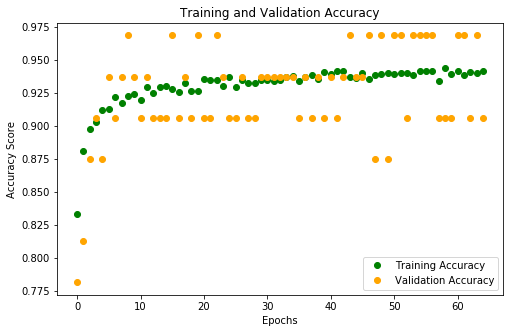

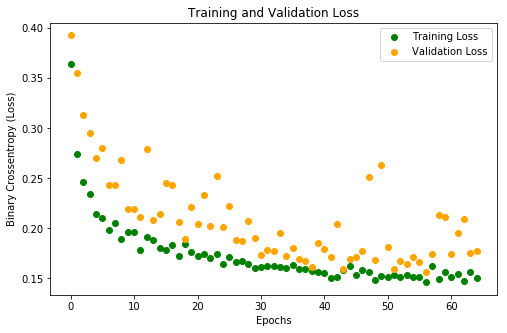

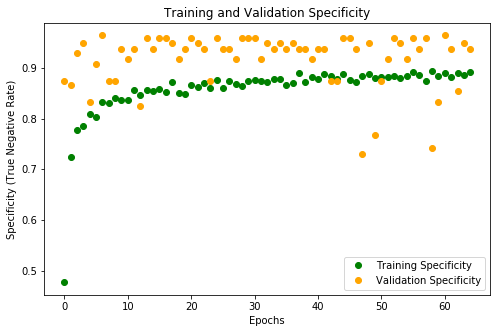

In [329]:
visualize(tl_cnn_model_2_history)

In [332]:
# evaluate
# This will take about 3.5 minutes to execute

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                    test_data_dir,
                    target_size=(96, 96),
                    batch_size=37,
                    class_mode='binary'
                    )

test_loss, test_acc, test_tn = tl_cnn_model_2.evaluate_generator(test_generator, steps=16)
y_hat_test = tl_cnn_model_2.predict_generator(test_generator, steps=16)
print('Generated {} predictions'.format(len(y_hat_test)))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test specificity:', test_tn)

Found 592 images belonging to 2 classes.
Generated 592 predictions
Test loss: 0.16442069387994707
Test accuracy: 0.940878376364708
Test specificity: 0.9139547049999237


**Some observations**:

- As hoped, the combination of transfer learning implemented *in conjunction with data augmentation* has resulted in my most powerful model yet.
- The model correctly identified 91% of the true-negatives in the training set while maintaining a 94% accuracy a loss of only 0.16. Strong all around.
- This model took almost 13 hours to train! In this case, high performance came with a significant computational cost.
- Anticipating a long training time, I made the decision this time around to resize the images to 96x96, whereas in previous iterations they were 128x128. Had I left it at 128x128, then I likely would've seen at least some marginal improvements in performance, but at the expense of more computational resources.
- All three evaluation metrics appear to be moving in the right direction even after the 65th and final epoch, meaning that additional epochs could prove beneficial.

### VI. Fine-tuned pretrained network + CNN

In the previous model, I froze the entire convolutional base. Having trained a classifier on the frozen base first, I'm now able to try to fine-tune the weights of the later layers on that base. (Without training a classifier on the frozen base first, there would be too much noise in the model, and initial epochs would overwrite any useful representations encoded in the pretrained model.)

Now, I'll unfreeze at least one of the deeper layers from VGG-19 and further fine-tune it/them to my particular image classification problem.

In [604]:
tl_cnn_model_2 = load_model('vgg19_65epochs_featext_method2.h5',
                            custom_objects={'specificity':specificity})

In [605]:
# see total number of trainable weights in saved model
# see which layers in the saved model are trainable

print("Total trainable weights: {}".format(len(tl_cnn_model_2.trainable_weights)))
tl_cnn_model_2.trainable_weights

Total trainable weights: 36


[<tf.Variable 'block1_conv1_29/kernel:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'block1_conv1_29/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'block1_conv2_29/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'block1_conv2_29/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'block2_conv1_29/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'block2_conv1_29/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'block2_conv2_29/kernel:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'block2_conv2_29/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'block3_conv1_29/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'block3_conv1_29/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'block3_conv2_29/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'block3_conv2_29/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'block3_conv3_29/kernel:0' shape=(3, 3, 256, 256) dtype=fl

After loading the previously trained model, which I had saved as `vgg19_65epochs_featext_method2.h5`, I notice that every layer, including all layers of the convolutional base, are trainable.

In my effort to fine-tune, I'm going to freeze every layer of the base up to the very last layer.

In [606]:
# preview architecture of model, taking note of param totals

tl_cnn_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten_12 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_89 (Dense)             (None, 132)               608388    
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 133       
Total params: 20,632,905
Trainable params: 20,632,905
Non-trainable params: 0
_________________________________________________________________


In [607]:
# preview architecture of base layer (vgg-19) within model
# take note of param totals

tl_cnn_model_2.layers[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

Because I am working with a relatively small dataset, and because my data is basically similar to that of VGG-19 (i.e., image classification), I'm only going to unfreeze the top layer of the base. I want to leverage previous knowledge as much as possible (and save some precious time, too).

In [608]:
# freeze base, with exception of the last layer

set_trainable = False
for layer in tl_cnn_model_2.layers[0].layers:
    if layer.name == 'block5_conv4':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [609]:
# sanity check on trainable/untrainable params in base

tl_cnn_model_2.layers[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [610]:
# sanity check on trainable/untrainable params in model

tl_cnn_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten_12 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_89 (Dense)             (None, 132)               608388    
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 133       
Total params: 38,297,481
Trainable params: 20,632,905
Non-trainable params: 17,664,576
_________________________________________________________________


In [611]:
# yet another sanity check, to see that only the last
# layer of base and the dense layers are trainable

print("Total trainable weights: {}".format(len(tl_cnn_model_2.trainable_weights)))
tl_cnn_model_2.trainable_weights

Total trainable weights: 6


[<tf.Variable 'block5_conv4_29/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>,
 <tf.Variable 'block5_conv4_29/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'dense_89_17/kernel:0' shape=(4608, 132) dtype=float32_ref>,
 <tf.Variable 'dense_89_17/bias:0' shape=(132,) dtype=float32_ref>,
 <tf.Variable 'dense_90_17/kernel:0' shape=(132, 1) dtype=float32_ref>,
 <tf.Variable 'dense_90_17/bias:0' shape=(1,) dtype=float32_ref>]

In [612]:
# recompile model

tl_cnn_model_2.compile(loss='binary_crossentropy', 
                   optimizer=optimizers.RMSprop(lr=1e-4), 
                   metrics=['acc', specificity])

In [613]:
# fit the model
# this will take almost 14 hours to execute

tl_cnn_model_2_finetuned_history = tl_cnn_model_2.fit_generator(train_generator,
                                        steps_per_epoch=109,
                                        # leave epochs the same for now
                                        # to measure effect of fine-tuning
                                        # and save resources
                                        epochs=65,
                                        validation_data=val_generator,
                                        validation_steps=4,
                                        shuffle=True)

Epoch 1/65
109/109 [==============================] - 732s 7s/step - loss: 0.3196 - acc: 0.8909 - specificity: 0.7838 - val_loss: 0.2622 - val_acc: 0.9062 - val_specificity: 0.9000
Epoch 2/65
109/109 [==============================] - 776s 7s/step - loss: 0.2073 - acc: 0.9148 - specificity: 0.8464 - val_loss: 0.2893 - val_acc: 0.8750 - val_specificity: 0.8125
Epoch 3/65
109/109 [==============================] - 836s 8s/step - loss: 0.1914 - acc: 0.9218 - specificity: 0.8395 - val_loss: 0.2580 - val_acc: 0.9062 - val_specificity: 0.7143
Epoch 4/65
109/109 [==============================] - 784s 7s/step - loss: 0.1848 - acc: 0.9297 - specificity: 0.8712 - val_loss: 0.2042 - val_acc: 0.9062 - val_specificity: 0.9167
Epoch 5/65
109/109 [==============================] - 750s 7s/step - loss: 0.1661 - acc: 0.9344 - specificity: 0.8722 - val_loss: 0.2985 - val_acc: 0.9062 - val_specificity: 0.8875
Epoch 6/65
109/109 [==============================] - 859s 8s/step - loss: 0.1690 - acc: 0.9350

109/109 [==============================] - 687s 6s/step - loss: 0.1189 - acc: 0.9564 - specificity: 0.9203 - val_loss: 0.2641 - val_acc: 0.9062 - val_specificity: 0.9167
Epoch 47/65
109/109 [==============================] - 687s 6s/step - loss: 0.1135 - acc: 0.9610 - specificity: 0.9208 - val_loss: 0.1809 - val_acc: 0.9062 - val_specificity: 0.9500
Epoch 48/65
109/109 [==============================] - 688s 6s/step - loss: 0.1254 - acc: 0.9545 - specificity: 0.9136 - val_loss: 0.1963 - val_acc: 0.9688 - val_specificity: 0.9167
Epoch 49/65
109/109 [==============================] - 689s 6s/step - loss: 0.1143 - acc: 0.9587 - specificity: 0.9147 - val_loss: 0.2284 - val_acc: 0.9062 - val_specificity: 0.9375
Epoch 50/65
109/109 [==============================] - 701s 6s/step - loss: 0.1153 - acc: 0.9562 - specificity: 0.9142 - val_loss: 0.2134 - val_acc: 0.9375 - val_specificity: 0.9500
Epoch 51/65
109/109 [==============================] - 691s 6s/step - loss: 0.1216 - acc: 0.9578 - spe

In [614]:
tl_cnn_model_2.save('vgg19_65epochs_finetuned.h5')

## 5. Interpret
#### Perform final evaluation on model of choice

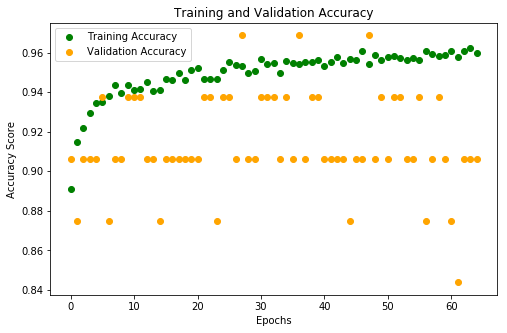

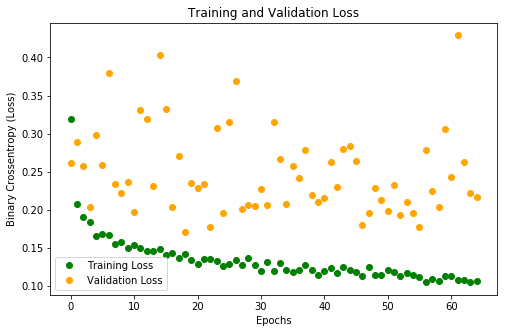

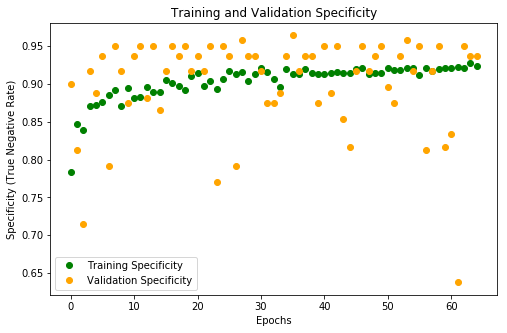

In [615]:
# visualize training and validation history

visualize(tl_cnn_model_2_finetuned_history)

In [616]:
# evaluate on testing data
# this will take about 3 minutes to execute

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                    test_data_dir,
                    target_size=(96, 96),
                    batch_size=37,
                    class_mode='binary'
                    )

test_loss, test_acc, test_tn = tl_cnn_model_2.evaluate_generator(test_generator, steps=16)
y_hat_test = tl_cnn_model_2.predict_generator(test_generator, steps=16)
print('Generated {} predictions'.format(len(y_hat_test)))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test specificity:', test_tn)

Found 592 images belonging to 2 classes.
Generated 592 predictions
Test loss: 0.20102009689435363
Test accuracy: 0.9358108080923557
Test specificity: 0.914450041949749


**Some observations**:

- At first glance, the plots above don't look to be quite as encouraging as those from the pre-fine-tuning classifier, when statistical trends in the validation data were more closely aligned with the training data.


- Recall that the model immediately preceding this one showed the following evaluation scores on its testing set:

    - Test loss: 0.16442
    - Test accuracy: 0.94088
    - Test specificity: 0.91395
    
    
- In this latest model, the specificity score is nearly identical as before, as is accuracy. But loss increased by about 0.035.


- The results remain strong, but nothing seems to have been gained by fine-tuning this time around. Perhaps going deeper into the convolutional base would have helped. Of course, doing that would have also taken a longer execution time. (It took nearly 14 hours with only the top layer of the base unfrozen!)

### The winning model:

Fifth time's a charm! The best performing model of the bunch was the frozen pre-trained network (VGG-19) with my own densely connected CNN on top, saved in this repository as `vgg19_65epochs_featext_method2.h5`.

# Future work

While I'm pleased with the results as they are, I am curious to see if improvements could be made by making a few changes:

- Increasing data by using images larger than 96x96.
- Add a few more fully connected layers on top of the pretrained layers.
- Borrowing the VGG-16 pre-trained network and comparing results to what I got using VGG-19.
- Use an even lower learning rate, such as 2e-5.
- Reduce computational expenses by training on downsampled data, until final model is selected.
- Get a more powerful laptop!